In [478]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from os import path
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

# Classification of Disaster Tweets with Machine Learning

In [479]:
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")
sample_submission = pd.read_csv("./datasets/sample_submission.csv")
df_train = train_data.copy()
df_test = test_data.copy()

In [480]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [481]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [482]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [483]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [484]:
print(df_train.duplicated(['text']).sum())

110


In [485]:
df_train = df_train.drop(index=df_train[df_train.duplicated('text', keep=False)].index)

In [486]:
len(df_train['keyword'].unique())

222

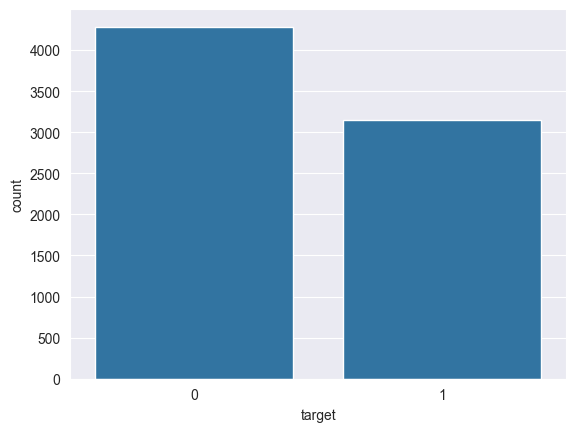

In [487]:
sns.countplot(x="target", data=df_train);

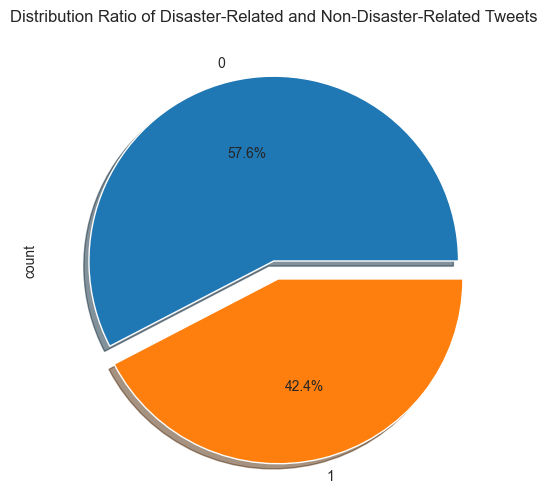

In [488]:
df_train["target"].value_counts().plot.pie(autopct='%1.1f%%', explode = [0, 0.1], figsize = (6, 6),shadow = True)
plt.title("Distribution Ratio of Disaster-Related and Non-Disaster-Related Tweets");

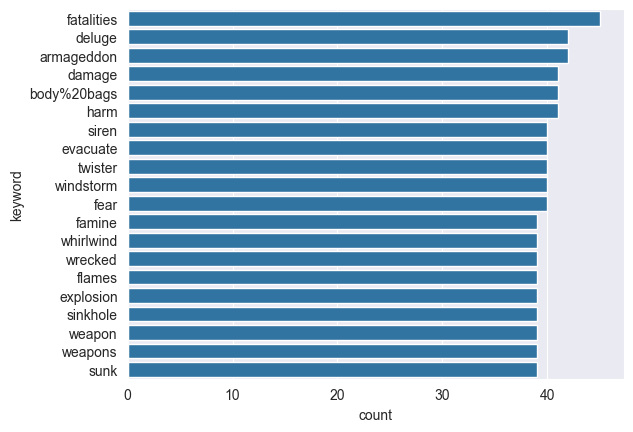

In [489]:
sns.barplot(y=df_train['keyword'].value_counts()[:20].index,x=df_train['keyword'].value_counts()[:20], orient='h');

In [490]:
encoder = LabelEncoder()
df_train['keyword'] = encoder.fit_transform(df_train['keyword'])
df_test['keyword'] = encoder.transform(df_test['keyword'])

In [491]:
df_train.head(250)

,id,keyword,location,text,target
0,1,221,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,221,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,221,NaN,All residents asked to 'shelter in place' are ...,1
3,6,221,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,221,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
253,360,6,NaN,U.S National Park Services Tonto National Fore...,1
254,361,6,CA physically- Boston Strong?,@TheEllenShow Please check into Salt River hor...,0
255,363,6,United States,Are souls punished withåÊannihilation? http://...,0
256,364,6,NaN,@CalFreedomMom @steph93065 not to mention a ma...,1


In [492]:
df_train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

<Axes: xlabel='count', ylabel='location'>

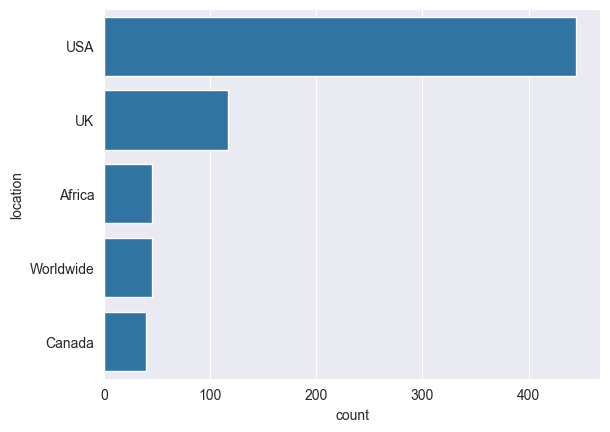

In [493]:
sns.barplot(y=df_train['location'].value_counts()[:5].index,x=df_train['location'].value_counts()[:5], orient='h')

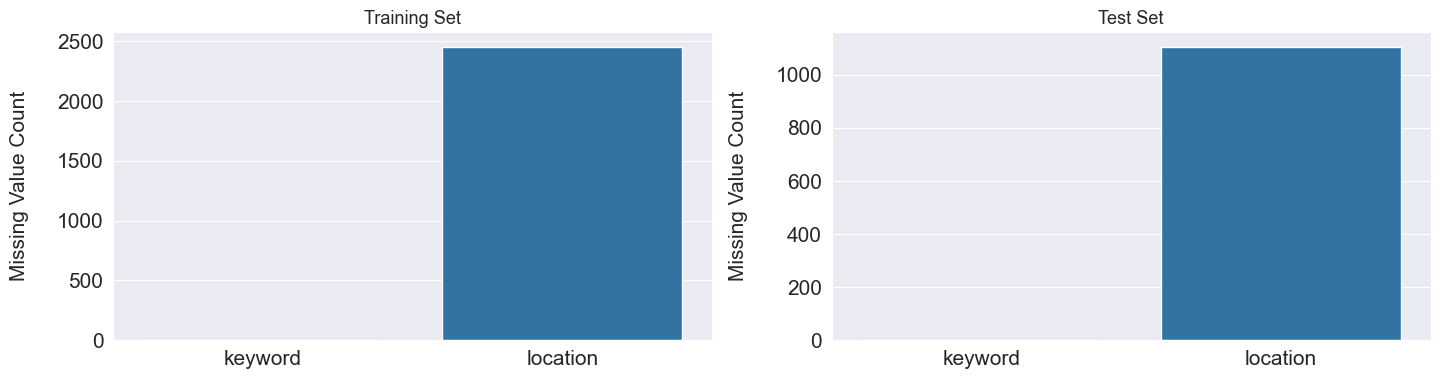

In [494]:
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

In [495]:
df_train["keyword"].fillna("None", inplace=True)
df_test["keyword"].fillna("None", inplace=True)

df_train["location"].fillna("None", inplace=True)
df_test["location"].fillna("None", inplace=True)

In [496]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [497]:
df

,id,keyword,location,text,target
0,1,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,4,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,5,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,6,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,7,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
10692,10861,221,no_{col},EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10693,10865,221,no_{col},Storm in RI worse than last hurricane. My city...,NaN
10694,10868,221,no_{col},Green Line derailment in Chicago http://t.co/U...,NaN
10695,10874,221,no_{col},MEG issues Hazardous Weather Outlook (HWO) htt...,NaN


In [498]:
df = df.drop(['id'], axis=1)

In [499]:
x_df = df.copy()

In [500]:
x_df["text"].str.len()

0         69
1         38
2        133
3         65
4         88
        ... 
10692     55
10693    139
10694     55
10695     65
10696     68
Name: text, Length: 10697, dtype: int64

<Figure size 1200x800 with 0 Axes>

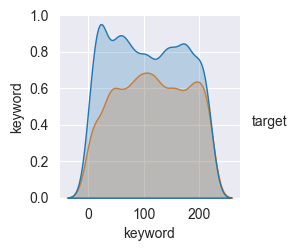

In [501]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=x_df, hue="target")
plt.show(fg)

In [502]:
df = df.reset_index(drop=True)
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0
5,221,no_{col},#RockyFire Update => California Hwy. 20 closed...,1.0
6,221,no_{col},#flood #disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I'm on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There's an emergency evacuation happening now ...,1.0
9,221,no_{col},I'm afraid that the tornado is coming to our a...,1.0


In [503]:
for i in range(len(df)):
    df["text"][i] = re.sub('(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#$\%\^\&\*_\-\=\+\\/\?\.\:\;\'\,]*)?', '', df["text"][i])
   
df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


In [504]:
for i in range(len(df)):
    df["text"][i] = re.sub('RT', '', df["text"][i])
    
df.head()

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this #earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask. Canada,1.0
2,221,no_{col},All residents asked to 'shelter in place' are ...,1.0
3,221,no_{col},"13,000 people receive #wildfires evacuation or...",1.0
4,221,no_{col},Just got sent this photo from Ruby #Alaska as ...,1.0


In [505]:
for i in range(len(df)):
    df["text"][i] = re.sub('[^a-zA-Z]', ' ', df["text"][i])
    
df.head(50)

,keyword,location,text,target
0,221,no_{col},Our Deeds are the Reason of this earthquake M...,1.0
1,221,no_{col},Forest fire near La Ronge Sask Canada,1.0
2,221,no_{col},All residents asked to shelter in place are ...,1.0
3,221,no_{col},people receive wildfires evacuation or...,1.0
4,221,no_{col},Just got sent this photo from Ruby Alaska as ...,1.0
5,221,no_{col},RockyFire Update California Hwy closed...,1.0
6,221,no_{col},flood disaster Heavy rain causes flash flood...,1.0
7,221,no_{col},I m on top of the hill and I can see a fire in...,1.0
8,221,no_{col},There s an emergency evacuation happening now ...,1.0
9,221,no_{col},I m afraid that the tornado is coming to our a...,1.0


In [506]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,keyword,location,text,target
0,221,no_{col},our deeds are the reason of this earthquake ma...,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},all residents asked to shelter in place are be...,1.0
3,221,no_{col},people receive wildfires evacuation orders in ...,1.0
4,221,no_{col},just got sent this photo from ruby alaska as s...,1.0


In [507]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')
sw

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [508]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [509]:
df.head(7000)

,keyword,location,text,target
0,221,no_{col},deeds reason earthquake may allah forgive us,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},residents asked shelter place notified officer...,1.0
3,221,no_{col},people receive wildfires evacuation orders cal...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...,...
6995,209,The D,debatequestionswewanttohear u start another wa...,1.0
6996,209,Still. ??S.A.N.D.O.S??,mama still thuggin world war zone homies inmat...,0.0
6997,209,no_{col},worldwatchesferguson florida govjaynixon clair...,1.0
6998,209,We're All Mad Here,packing ct aka room looks like war zone,0.0


In [510]:
least = pd.Series(" ".join(df["text"]).split()).value_counts().reset_index()
least.columns = ['words', 'tf']
least.head()

,words,tf
0,amp,506
1,like,487
2,fire,357
3,get,337
4,new,329


In [511]:
sil = least[least["tf"] < 50]
sil

,words,tf
367,wreckage,49
368,hijacking,49
369,hostages,49
370,desolation,49
371,tsunami,49
...,...,...
20077,oiled,1
20078,milf,1
20079,risen,1
20080,hasaka,1


In [512]:
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

In [513]:
from textblob import Word
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [514]:
df[:20]

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
5,221,no_{col},rockyfire update california hwy closed directi...,1.0
6,221,no_{col},flood disaster heavy rain cause flash flooding...,1.0
7,221,no_{col},top hill see fire wood,1.0
8,221,no_{col},emergency evacuation happening building across...,1.0
9,221,no_{col},afraid tornado coming area,1.0


In [515]:
tf1 = pd.Series(' '.join(df['text']).lower().split()).value_counts().reset_index()
tf1.columns = ['words', 'tf']

In [516]:
tf1.head()

,words,tf
0,fire,511
1,amp,506
2,like,490
3,get,382
4,u,373


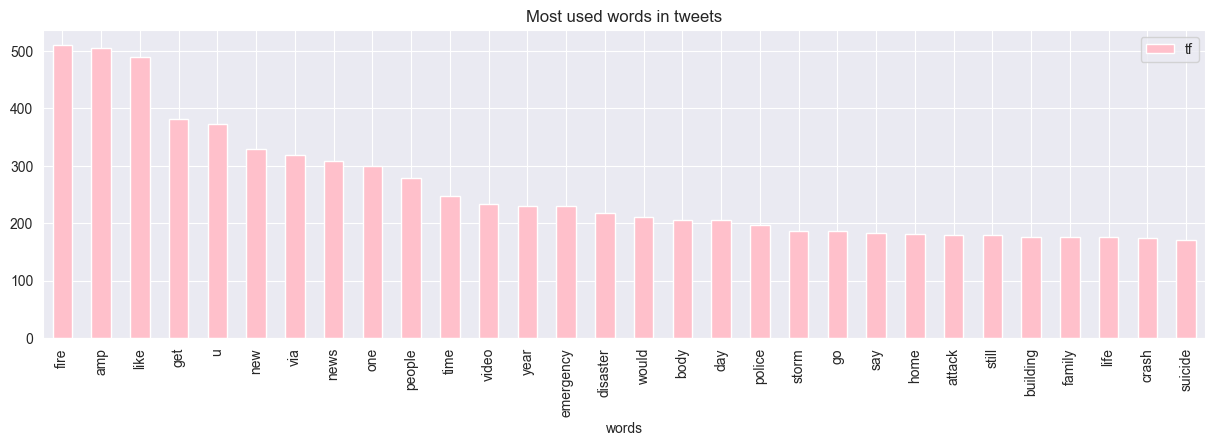

In [517]:
tf1[:30].plot.bar(x="words", y="tf", figsize=(15,4), color="pink");
plt.title('Most used words in tweets');

In [518]:
non_disaster_tweets_count = Counter(" ".join(df[df['target']==0]["text"]).split()).most_common(20)
non_disaster_tweets_count_df = pd.DataFrame(non_disaster_tweets_count, columns=["words", "freq"])
print("The 20 most used words in non-disaster tweets:")
non_disaster_tweets_count_df

The 20 most used words in non-disaster tweets:


,words,freq
0,like,254
1,amp,207
2,get,185
3,new,171
4,u,155
5,one,139
6,body,119
7,time,106
8,day,104
9,video,101


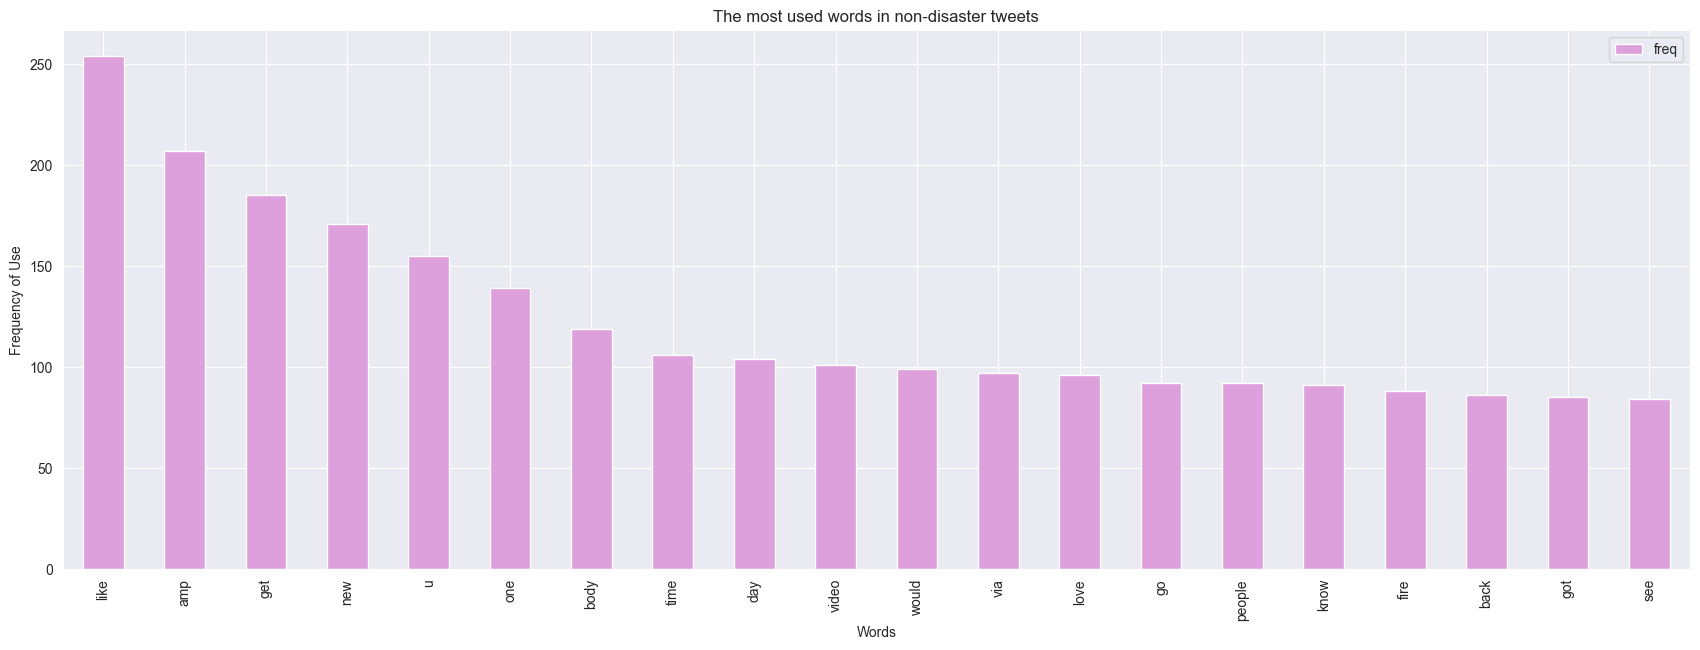

In [519]:
non_disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="plum")
plt.title('The most used words in non-disaster tweets')
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

In [520]:
disaster_tweets_count = Counter(" ".join(df[df['target']==1]["text"]).split()).most_common(20)
disaster_tweets_count_df = pd.DataFrame(disaster_tweets_count, columns=["words", "freq"])
print("The 20 most used words in disaster-related tweets:")
disaster_tweets_count_df

The 20 most used words in disaster-related tweets:


,words,freq
0,fire,256
1,news,147
2,amp,133
3,via,117
4,california,113
5,disaster,112
6,u,110
7,police,106
8,suicide,104
9,people,102


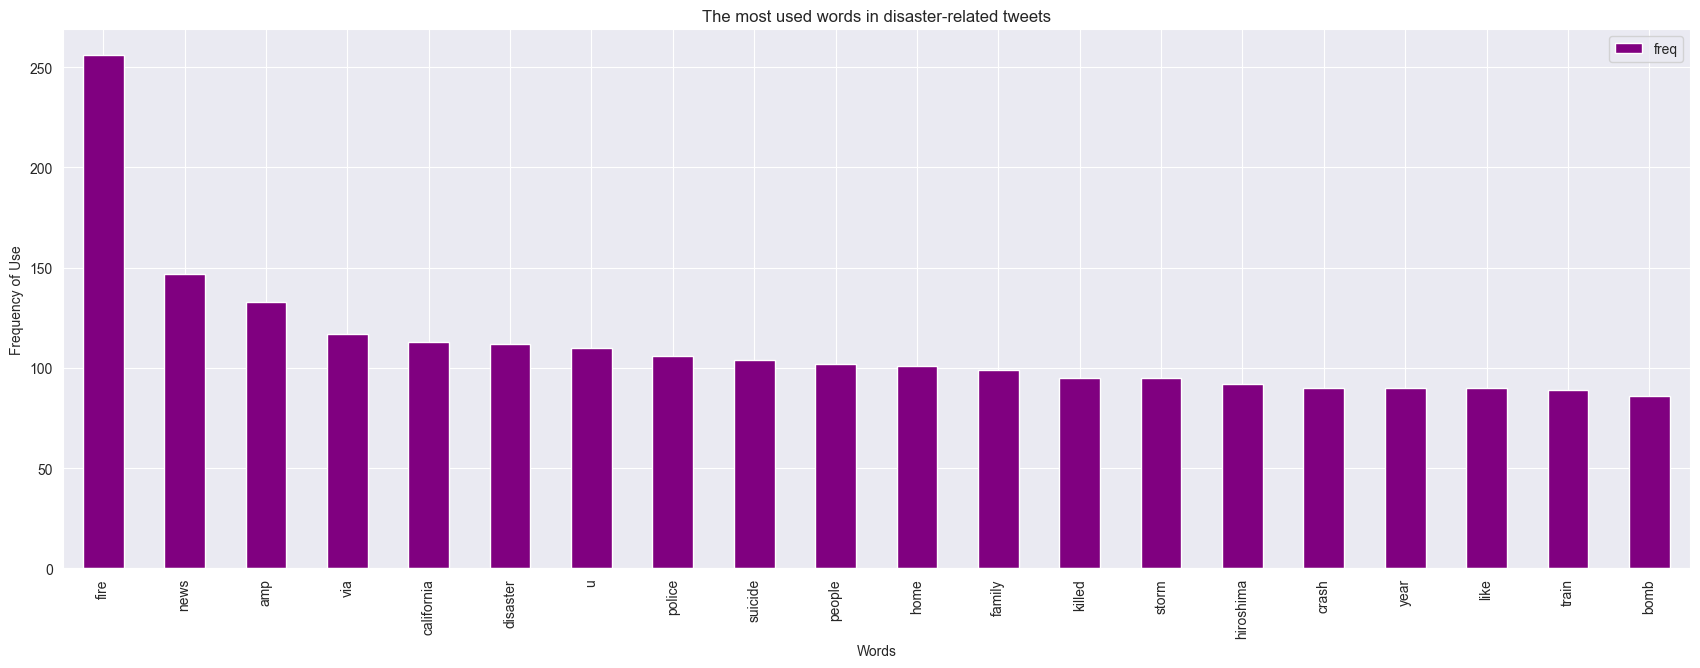

In [521]:
disaster_tweets_count_df.plot.bar(x="words", y="freq", figsize=(21,7), color="purple")
plt.title('The most used words in disaster-related tweets')
plt.xlabel('Words')
plt.ylabel('Frequency of Use');

# Train - Test

In [522]:
y = df.target[:len(df_test)]
X = df.drop(["target","location"],axis=1)[:len(df_test)]

In [523]:
X, y

(      keyword                                               text
 0         221         deed reason earthquake may allah forgive u
 1         221              forest fire near la ronge sask canada
 2         221  resident asked shelter place notified officer ...
 3         221  people receive wildfire evacuation order calif...
 4         221  got sent photo ruby alaska smoke wildfire pour...
 ...       ...                                                ...
 3258       96  rocky fire northern california swell acre evac...
 3259       96  trafford centre film fan angry odeon cinema ev...
 3260       96   dead missing family evacuated due flood bukidnon
 3261       96  missleylaha get buy one last london show fire ...
 3262       96  got evacuated movie theatre emergency saw peop...
 
 [3263 rows x 2 columns],
 0       1.0
 1       1.0
 2       1.0
 3       1.0
 4       1.0
        ... 
 3258    1.0
 3259    1.0
 3260    1.0
 3261    0.0
 3262    1.0
 Name: target, Length: 3263, dtype: f

In [524]:
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.30)
X_train.head()

,keyword,text
1556,45,lower striked would gone even otm could really...
435,11,owner chicago area gay bar admits arson scheme...
1829,53,starflame girl yeah crush
237,6,evildead annihilation civilization
2820,83,karijobe band killed tonight almost loud enoug...


# Count Vectors

In [525]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])

CountVectorizer()

In [526]:
x_train_count = vectorizer.fit_transform(X_train['text'])
x_test_count = vectorizer.transform(X_test['text'])

In [527]:
vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aashiqui', 'ab'], dtype=object)

# # TF-IDF Vectors (words, characters, n-grams)
# Word Level TF-IDF

In [528]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(X_train['text'])
x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(X_test['text'])

In [529]:
tf_idf_word_vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aashiqui', 'ab'], dtype=object)

# Ngram Level TF-IDF

In [530]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(X_train['text'])
x_train_tf_idf_ngarm = tf_idf_ngram_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(X_test['text'])

In [531]:
tf_idf_ngram_vectorizer.get_feature_names_out()[:5]

array(['aa battery', 'aa battery swear', 'aa mgm', 'aa mgm grand',
       'aaaaaaallll even'], dtype=object)

# Characters level TF-IDF

In [532]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(X_train['text'])
x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(X_train['text'])
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(X_test['text'])

In [533]:
tf_idf_chars_vectorizer.get_feature_names_out()[:5]

array([' a', ' aa', ' ab', ' ac', ' ad'], dtype=object)

# Creating a Model

In [534]:
all_performances = pd.DataFrame()
list_clf_name = []
list_x_test = []
list_pred = []
list_model = []

In [535]:
def fit_model(model, x_train_x, y_train):
    x_model = model.fit(x_train_x,y_train)
    return x_model

In [536]:
def model_name(model, vector_name):
    model_name = model.__class__.__name__
    suffix = ""
    
    if vector_name == "c":
        suffix = "_count"
    elif vector_name == "n":
        suffix = "_ngram"
    elif vector_name == "w":
        suffix = "_word"
    elif vector_name == "ch":
        suffix = "_chars"

    if "_tuned" in vector_name:  # Explicitly check for tuning
        return f"{model_name}{suffix}_tuned"
    
    return f"{model_name}{suffix}"

In [537]:
def add_list(name, model, x_test_x, y_pred):
    global list_clf_name, list_pred, list_model, list_x_test
    list_clf_name.append(name)
    list_model.append(model)
    list_x_test.append(x_test_x)
    list_pred.append(y_pred)

In [538]:
def add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC):
    global all_performances
    models = pd.DataFrame([[name, training_set_score, test_set_score, precision, recall, f1_score, AUC]],
                         columns=["model_name","training_set_score", "test_set_score",
                                  "precision", "recall", "f1_score", "AUC"])
    all_performances = pd.concat([all_performances, models], ignore_index=True)
    all_performances= all_performances.drop_duplicates()

In [539]:
def model_performance(x_train_x, x_test_x, model, vector_name):
    
    x_model = fit_model(model, x_train_x, y_train)
    
    name = model_name(model, vector_name)
    y_pred = x_model.predict(x_test_x)
    training_set_score= x_model.score(x_train_x, y_train)
    test_set_score = x_model.score(x_test_x, y_test)
    precision = mt.precision_score(y_test,y_pred)
    recall = mt.recall_score(y_test,y_pred)
    f1_score= mt.f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred) 
    
    add_list(name, model, x_test_x, y_pred)
    add_all_performances(name, training_set_score, test_set_score, precision, recall, f1_score, AUC)
    
    print(classification_report(y_test, y_pred, target_names=['non-disaster','disaster']))

# Logistic Regression

In [540]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_count, x_test_count, log_reg, "c")

              precision    recall  f1-score   support

non-disaster       0.79      0.91      0.84       581
    disaster       0.82      0.64      0.72       398

    accuracy                           0.80       979
   macro avg       0.80      0.77      0.78       979
weighted avg       0.80      0.80      0.79       979


In [541]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, log_reg, "w")

              precision    recall  f1-score   support

non-disaster       0.76      0.95      0.85       581
    disaster       0.88      0.57      0.70       398

    accuracy                           0.80       979
   macro avg       0.82      0.76      0.77       979
weighted avg       0.81      0.80      0.78       979


In [542]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, log_reg, "n")

              precision    recall  f1-score   support

non-disaster       0.66      0.98      0.79       581
    disaster       0.92      0.26      0.40       398

    accuracy                           0.69       979
   macro avg       0.79      0.62      0.60       979
weighted avg       0.77      0.69      0.63       979


In [543]:
log_reg = linear_model.LogisticRegression()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, log_reg, "ch")

              precision    recall  f1-score   support

non-disaster       0.75      0.90      0.82       581
    disaster       0.79      0.56      0.66       398

    accuracy                           0.76       979
   macro avg       0.77      0.73      0.74       979
weighted avg       0.76      0.76      0.75       979


# Naive Bayes

In [544]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_count, x_test_count, nb, "c")

              precision    recall  f1-score   support

non-disaster       0.80      0.85      0.83       581
    disaster       0.76      0.70      0.73       398

    accuracy                           0.79       979
   macro avg       0.78      0.77      0.78       979
weighted avg       0.79      0.79      0.79       979


In [545]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, nb, "w")

              precision    recall  f1-score   support

non-disaster       0.76      0.93      0.84       581
    disaster       0.85      0.58      0.69       398

    accuracy                           0.79       979
   macro avg       0.80      0.75      0.76       979
weighted avg       0.80      0.79      0.78       979


In [546]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, nb, "n")

              precision    recall  f1-score   support

non-disaster       0.69      0.97      0.81       581
    disaster       0.89      0.37      0.53       398

    accuracy                           0.73       979
   macro avg       0.79      0.67      0.67       979
weighted avg       0.77      0.73      0.69       979


In [547]:
nb = naive_bayes.MultinomialNB()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, nb, "ch")

              precision    recall  f1-score   support

non-disaster       0.71      0.97      0.82       581
    disaster       0.90      0.41      0.57       398

    accuracy                           0.74       979
   macro avg       0.80      0.69      0.69       979
weighted avg       0.79      0.74      0.71       979


# Random Forests

In [548]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_count, x_test_count, rf, "c")

              precision    recall  f1-score   support

non-disaster       0.77      0.93      0.84       581
    disaster       0.85      0.59      0.70       398

    accuracy                           0.79       979
   macro avg       0.81      0.76      0.77       979
weighted avg       0.80      0.79      0.78       979


In [549]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, rf, "w")

              precision    recall  f1-score   support

non-disaster       0.77      0.89      0.82       581
    disaster       0.79      0.60      0.68       398

    accuracy                           0.77       979
   macro avg       0.78      0.75      0.75       979
weighted avg       0.78      0.77      0.77       979


In [550]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, rf, "n")

              precision    recall  f1-score   support

non-disaster       0.66      0.97      0.79       581
    disaster       0.87      0.27      0.42       398

    accuracy                           0.69       979
   macro avg       0.76      0.62      0.60       979
weighted avg       0.74      0.69      0.64       979


In [551]:
rf = ensemble.RandomForestClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, rf, "ch")

              precision    recall  f1-score   support

non-disaster       0.73      0.92      0.82       581
    disaster       0.82      0.51      0.63       398

    accuracy                           0.76       979
   macro avg       0.78      0.72      0.72       979
weighted avg       0.77      0.76      0.74       979


# XGBoost

In [552]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_count, x_test_count, xgb, "c")

              precision    recall  f1-score   support

non-disaster       0.77      0.90      0.83       581
    disaster       0.80      0.61      0.69       398

    accuracy                           0.78       979
   macro avg       0.78      0.75      0.76       979
weighted avg       0.78      0.78      0.77       979


In [553]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_word, x_test_tf_idf_word, xgb, "w")

              precision    recall  f1-score   support

non-disaster       0.75      0.92      0.83       581
    disaster       0.82      0.56      0.67       398

    accuracy                           0.77       979
   macro avg       0.79      0.74      0.75       979
weighted avg       0.78      0.77      0.76       979


In [554]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_ngarm, x_test_tf_idf_ngram, xgb, "n")

              precision    recall  f1-score   support

non-disaster       0.64      0.98      0.77       581
    disaster       0.85      0.18      0.30       398

    accuracy                           0.65       979
   macro avg       0.74      0.58      0.53       979
weighted avg       0.72      0.65      0.58       979


In [555]:
xgb = xgboost.XGBClassifier()
model_performance(x_train_tf_idf_chars, x_test_tf_idf_chars, xgb, "ch")

              precision    recall  f1-score   support

non-disaster       0.74      0.81      0.77       581
    disaster       0.68      0.58      0.63       398

    accuracy                           0.72       979
   macro avg       0.71      0.70      0.70       979
weighted avg       0.72      0.72      0.71       979


# Performance Evaluation

In [556]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score

def display_all_confusion_matrix():
    num_classifiers = len(list_clf_name)
    cols = 4
    rows = -(-num_classifiers // cols)
    
    f, ax = plt.subplots(rows, cols, figsize=(20, rows * 5), sharey='row')
    ax = ax.flatten()

    for i in range(len(list_clf_name)):
        cf_matrix = confusion_matrix(y_test, list_pred[i])
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=ax[i], xticks_rotation=45)
        disp.ax_.set_title(list_clf_name[i]+"\nAccuracy:{accuracy:.4f}\nAUC:{auc:.4f}"
                           .format(accuracy= accuracy_score(y_test, list_pred[i]),auc= roc_auc_score(y_test, list_pred[i])),
                             fontsize=14)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')


    for j in range(num_classifiers, len(ax)):
        f.delaxes(ax[j])

    f.text(0.5, 0.04, 'Predicted label', ha='center', fontsize=16)
    f.text(0.04, 0.5, 'True label', va='center', rotation='vertical', fontsize=16)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    cbar_ax = f.add_axes([0.92, 0.15, 0.02, 0.7])
    f.colorbar(disp.im_, cax=cbar_ax)
    plt.show()

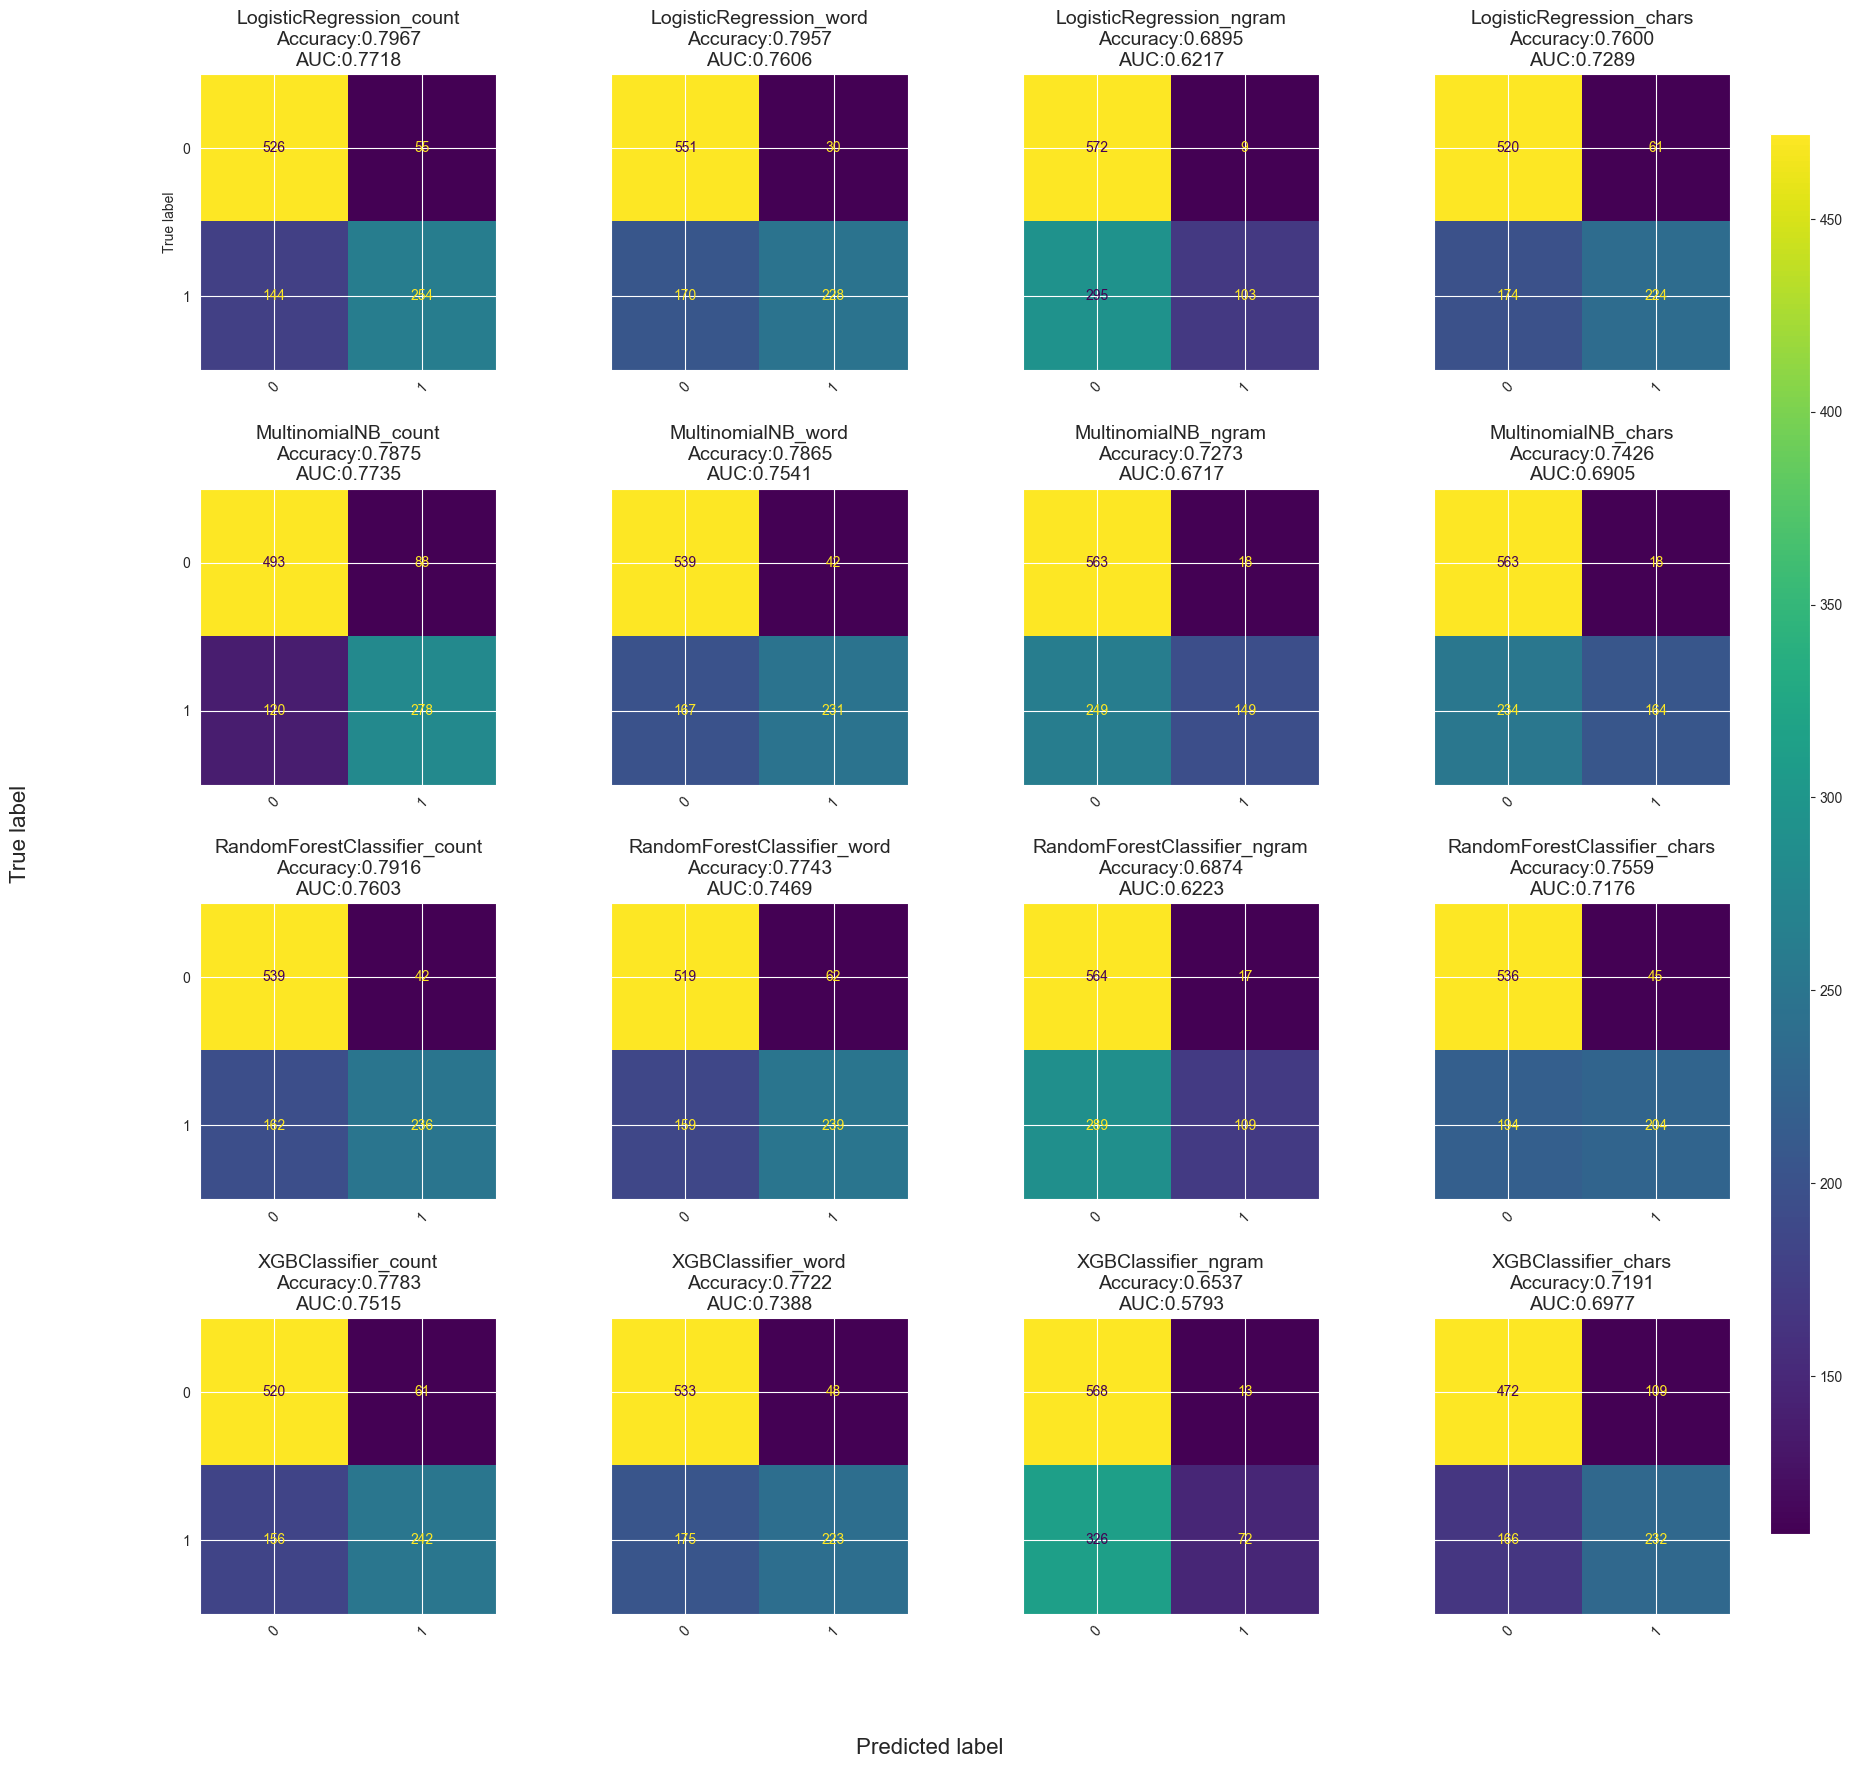

In [557]:
display_all_confusion_matrix()

In [558]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
4,MultinomialNB_count,0.948336,0.787538,0.759563,0.698492,0.727749,0.773515
0,LogisticRegression_count,0.980298,0.796731,0.822006,0.638191,0.718529,0.771763
8,RandomForestClassifier_count,0.993433,0.791624,0.848921,0.592965,0.698225,0.760338
1,LogisticRegression_word,0.889229,0.795710,0.883721,0.572864,0.695122,0.760615
12,XGBClassifier_count,0.864711,0.778345,0.798680,0.608040,0.690442,0.751524
5,MultinomialNB_word,0.921629,0.786517,0.846154,0.580402,0.688525,0.754056
9,RandomForestClassifier_word,0.993433,0.774259,0.794020,0.600503,0.683834,0.746895
13,XGBClassifier_word,0.899737,0.772217,0.822878,0.560302,0.666667,0.738843
3,LogisticRegression_chars,0.862084,0.759959,0.785965,0.562814,0.655930,0.728911
11,RandomForestClassifier_chars,0.993870,0.755873,0.819277,0.512563,0.630603,0.717555


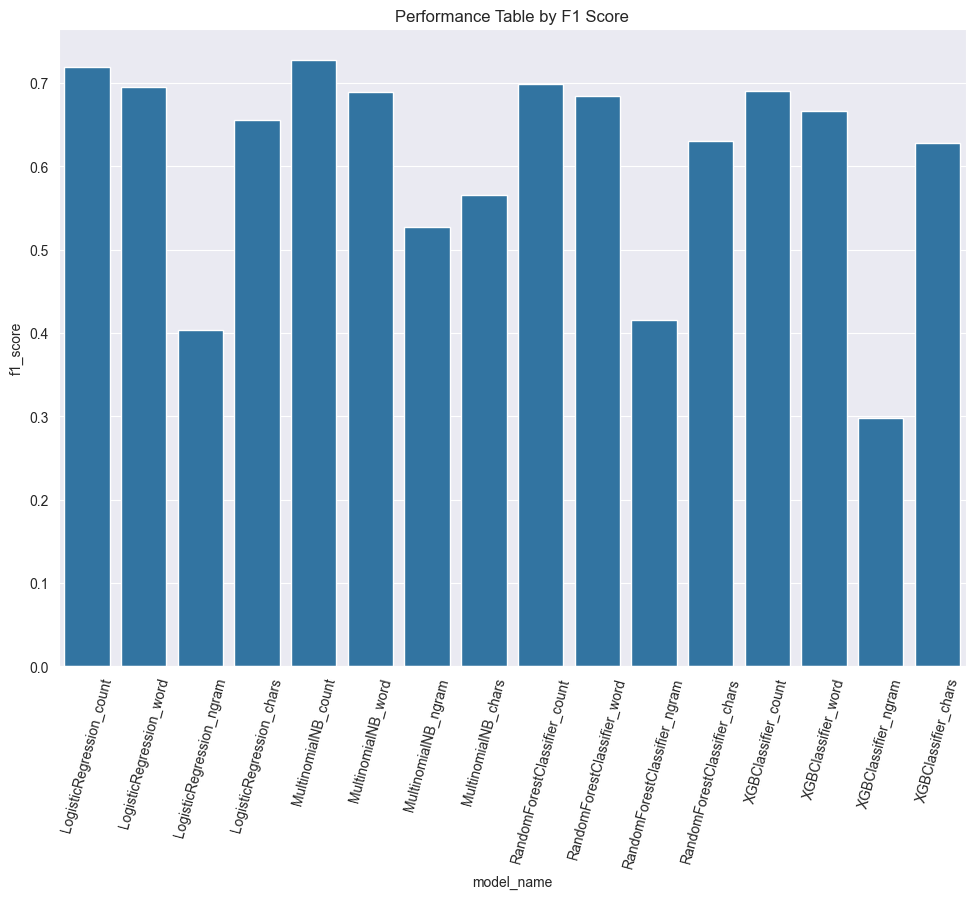

In [559]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=75)
sns.barplot(x="model_name", y ="f1_score", data = all_performances, ax=ax);
title = plt.title('Performance Table by F1 Score')

# Hyperparameter Tuning
# Naive Bayes

In [560]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 11.25, 11.5, 11.75],
    'fit_prior': [True, False],
    'class_prior': [None, [0.3, 0.7], [0.5, 0.5]]
}

In [561]:
classifier = naive_bayes.MultinomialNB()

In [562]:
from sklearn.model_selection import StratifiedKFold

grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    verbose=2
)

# Count Vector

In [563]:
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .alpha=0.01, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END .alpha=0.01, class_prior=[0.3, 0.7], f

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='f1', verbose=2)

In [564]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 1, 'class_prior': None, 'fit_prior': True}
Best Score:  0.7246219234446791


In [565]:
best_classifier = grid_search.best_estimator_
accuracy = best_classifier.score(x_test_count, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7875383043922369


# Word Level TF-IDF

In [566]:
grid_search.fit(x_train_tf_idf_word, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END .......alpha=0.01, class_prior=None, fit_prior=True; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END ......alpha=0.01, class_prior=None, fit_prior=False; total time=   0.0s
[CV] END .alpha=0.01, class_prior=[0.3, 0.7], fit_prior=True; total time=   0.0s
[CV] END .alpha=0.01, class_prior=[0.3, 0.7], f

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 11.25, 11.5, 11.75],
                         'class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
                         'fit_prior': [True, False]},
             scoring='f1', verbose=2)

In [567]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'alpha': 1, 'class_prior': None, 'fit_prior': False}
Best Score:  0.7135955791425067


# Logistic Regression (Count Vector)

In [568]:
param_grid = {
    'C': [0.25,0.3,0.35],  # inverse regularization strength
    'penalty': ['l1', 'l2'],  # regularization type
    'solver': ['liblinear', 'saga']  # optimization algorithm
}

In [569]:
classifier = linear_model.LogisticRegression()

In [570]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Tune for F1 score
    verbose=2
)
grid_search.fit(x_train_count, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.25, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.25, penalty=l2, solv

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.25, 0.3, 0.35], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1', verbose=2)

In [571]:
# Print the best parameter combination and score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.35, 'penalty': 'l2', 'solver': 'saga'}
Best Score:  0.6902558617474706


# Best Performing Model

In [572]:
best_classifier = grid_search.best_estimator_

In [573]:
best_classifier

LogisticRegression(C=0.35, solver='saga')

In [574]:
test_f1_score = f1_score(y_test, best_classifier.predict(x_test_count))
test_accuracy = best_classifier.score(x_test_count, y_test)

print("Test F1 Score:", test_f1_score)
print("Test Accuracy:", test_accuracy)

Test F1 Score: 0.7215909090909091
Test Accuracy: 0.7997957099080695


In [575]:
model_performance(x_train_count, x_test_count, best_classifier, "c_tuned")

              precision    recall  f1-score   support

non-disaster       0.79      0.91      0.84       581
    disaster       0.83      0.64      0.72       398

    accuracy                           0.80       979
   macro avg       0.81      0.77      0.78       979
weighted avg       0.80      0.80      0.79       979


In [576]:
all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,training_set_score,test_set_score,precision,recall,f1_score,AUC
4,MultinomialNB_count,0.948336,0.787538,0.759563,0.698492,0.727749,0.773515
16,LogisticRegression_tuned,0.947898,0.799796,0.830065,0.638191,0.721591,0.774345
0,LogisticRegression_count,0.980298,0.796731,0.822006,0.638191,0.718529,0.771763
8,RandomForestClassifier_count,0.993433,0.791624,0.848921,0.592965,0.698225,0.760338
1,LogisticRegression_word,0.889229,0.795710,0.883721,0.572864,0.695122,0.760615
12,XGBClassifier_count,0.864711,0.778345,0.798680,0.608040,0.690442,0.751524
5,MultinomialNB_word,0.921629,0.786517,0.846154,0.580402,0.688525,0.754056
9,RandomForestClassifier_word,0.993433,0.774259,0.794020,0.600503,0.683834,0.746895
13,XGBClassifier_word,0.899737,0.772217,0.822878,0.560302,0.666667,0.738843
3,LogisticRegression_chars,0.862084,0.759959,0.785965,0.562814,0.655930,0.728911


In [578]:
df

,keyword,location,text,target
0,221,no_{col},deed reason earthquake may allah forgive u,1.0
1,221,no_{col},forest fire near la ronge sask canada,1.0
2,221,no_{col},resident asked shelter place notified officer ...,1.0
3,221,no_{col},people receive wildfire evacuation order calif...,1.0
4,221,no_{col},got sent photo ruby alaska smoke wildfire pour...,1.0
...,...,...,...,...
10692,221,no_{col},eahquake safety los angeles safety fastener xrwn,NaN
10693,221,no_{col},storm ri worse last hurricane city amp others ...,NaN
10694,221,no_{col},green line derailment chicago,NaN
10695,221,no_{col},meg issue hazardous weather outlook hwo,NaN


In [579]:
X_pred = df[len(df_train):].drop("target",axis=1)
X_pred["text"]

7434                           happened terrible car crash
7435     heard earthquake different city stay safe ever...
7436     forest fire spot pond goose fleeing across str...
7437                  apocalypse lighting spokane wildfire
7438                    typhoon soudelor kill china taiwan
                               ...                        
10692     eahquake safety los angeles safety fastener xrwn
10693    storm ri worse last hurricane city amp others ...
10694                        green line derailment chicago
10695              meg issue hazardous weather outlook hwo
10696    cityofcalgary activated municipal emergency pl...
Name: text, Length: 3263, dtype: object

In [580]:
X_train['text']

1556    lower striked would gone even otm could really...
435     owner chicago area gay bar admits arson scheme...
1829                            starflame girl yeah crush
237                    evildead annihilation civilization
2820    karijobe band killed tonight almost loud enoug...
                              ...                        
1095    third generation atomic bombed survivor photo ...
1130       th anniversary hiroshima atomic bombing marked
1294    parent taking kid burning man one year old thi...
860     man somebody gotta stop sbee dude fuckin funny...
3174              fnaf talkmc stand engulfed fire smiling
Name: text, Length: 2284, dtype: object

In [581]:
vectorizer = CountVectorizer()
vectorizer.fit_transform(X_train['text'])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 19894 stored elements and shape (2284, 6819)>

In [582]:
X_pred_count = vectorizer.transform(X_pred["text"])

In [583]:
vectorizer.get_feature_names_out()[:5]

array(['aa', 'aaaaaaallll', 'aace', 'aashiqui', 'ab'], dtype=object)

In [584]:
y_pred = best_classifier.predict(X_pred_count)

In [585]:
data = {'tweet': X_pred["text"], 'location': X_pred['location'] , 'predicted_label': y_pred}
predicted_data = pd.DataFrame(data).reset_index(drop=True)

In [586]:
predicted_data['actual_label'] = sample_submission["target"].reset_index(drop=True)

In [587]:
predicted_data

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,heard earthquake different city stay safe ever...,no_{col},1.0,0
2,forest fire spot pond goose fleeing across str...,no_{col},1.0,0
3,apocalypse lighting spokane wildfire,no_{col},1.0,0
4,typhoon soudelor kill china taiwan,no_{col},0.0,0
...,...,...,...,...
3258,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
3259,storm ri worse last hurricane city amp others ...,no_{col},1.0,0
3260,green line derailment chicago,no_{col},1.0,0
3261,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [588]:
sample_submission["target"].unique()

array([0])

In [589]:
right_predictions = predicted_data[(predicted_data["predicted_label"] == predicted_data["actual_label"])]
right_predictions = right_predictions.reset_index(drop=True)
right_predictions

,tweet,location,predicted_label,actual_label
0,happened terrible car crash,no_{col},0.0,0
1,typhoon soudelor kill china taiwan,no_{col},0.0,0
2,probably still show life arsenal yesterday eh eh,no_{col},0.0,0
3,hey,no_{col},0.0,0
4,nice hat,no_{col},0.0,0
...,...,...,...,...
2373,see yr old pkk suicide bomber detonated bomb t...,no_{col},0.0,0
2374,conference attendee blue line airport derailed...,no_{col},0.0,0
2375,eahquake safety los angeles safety fastener xrwn,no_{col},0.0,0
2376,meg issue hazardous weather outlook hwo,no_{col},0.0,0


In [590]:
accuracy = len(right_predictions)*100/len(predicted_data)
accuracy

72.87771988967208

In [591]:
import psycopg2
from psycopg2 import OperationalError

try:
    conn = psycopg2.connect(
        dbname="machineLearning",
        user="postgres",
        password="P@$$w0rd",
        host="localhost",
        port="5432"
    )

    cur = conn.cursor()
    print("Connection successful!")

except OperationalError as e:
    print(f"Error: Unable to connect to the database\n{e}")

finally:
    try:
        cur.close()
        conn.close()
    except NameError:
        pass

Connection successful!


In [592]:
import psycopg2

db_params = {
    "dbname": "machineLearning",
    "user": "postgres",
    "password": "P@$$w0rd",
    "host": "localhost",
    "port": "5432",
}

try:
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()

    cur.execute('''
        CREATE TABLE IF NOT EXISTS predicted_tweets (
            id SERIAL PRIMARY KEY,
            tweet TEXT,
            location TEXT
        )
    ''')
    
    for i in range(len(right_predictions)):
        cur.execute('''
            INSERT INTO predicted_tweets (tweet, location) VALUES (%s, %s)
        ''', (right_predictions['tweet'][i], right_predictions['location'][i]))
    
    conn.commit()
    print("Data inserted successfully!")

except psycopg2.Error as e:
    print(f"An error occurred: {e}")

finally:
    if conn:
        conn.close()

Data inserted successfully!
